In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import math
import numexpr as ne
import cupy as cp
import sys
import numba
import numba.cuda
from skimage.transform import rescale as skitres
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [2]:
warnings.filterwarnings('ignore')
#sys.path.append('/home/cades/Codes/stemtools')
sys.path.append('C:/Debangshu Research/stemtools')
sys.path.append('C:/Debangshu Research/ptycho_testing/ptychogpu/pty')
import stemtools as st
import gpu_ssb
%load_ext autoreload
%autoreload 2

In [3]:
loaded_data = np.load('C:/Debangshu Research/ptycho_testing/ptychotest.npz',allow_pickle=True)
#loaded_data = np.load('/home/cades/ptychotest.npz',allow_pickle=True)
loaded_data.files

['Data_4D', 'DataADF', 'info_4D', 'infoADF']

In [4]:
st.tic()
Data_4D = loaded_data[loaded_data.files[0]]
DataADF = loaded_data[loaded_data.files[1]]
info_4D = np.ndarray.tolist(loaded_data[loaded_data.files[2]])
infoADF = np.ndarray.tolist(loaded_data[loaded_data.files[3]])
st.toc()

Elapsed time: 12.537465 seconds.



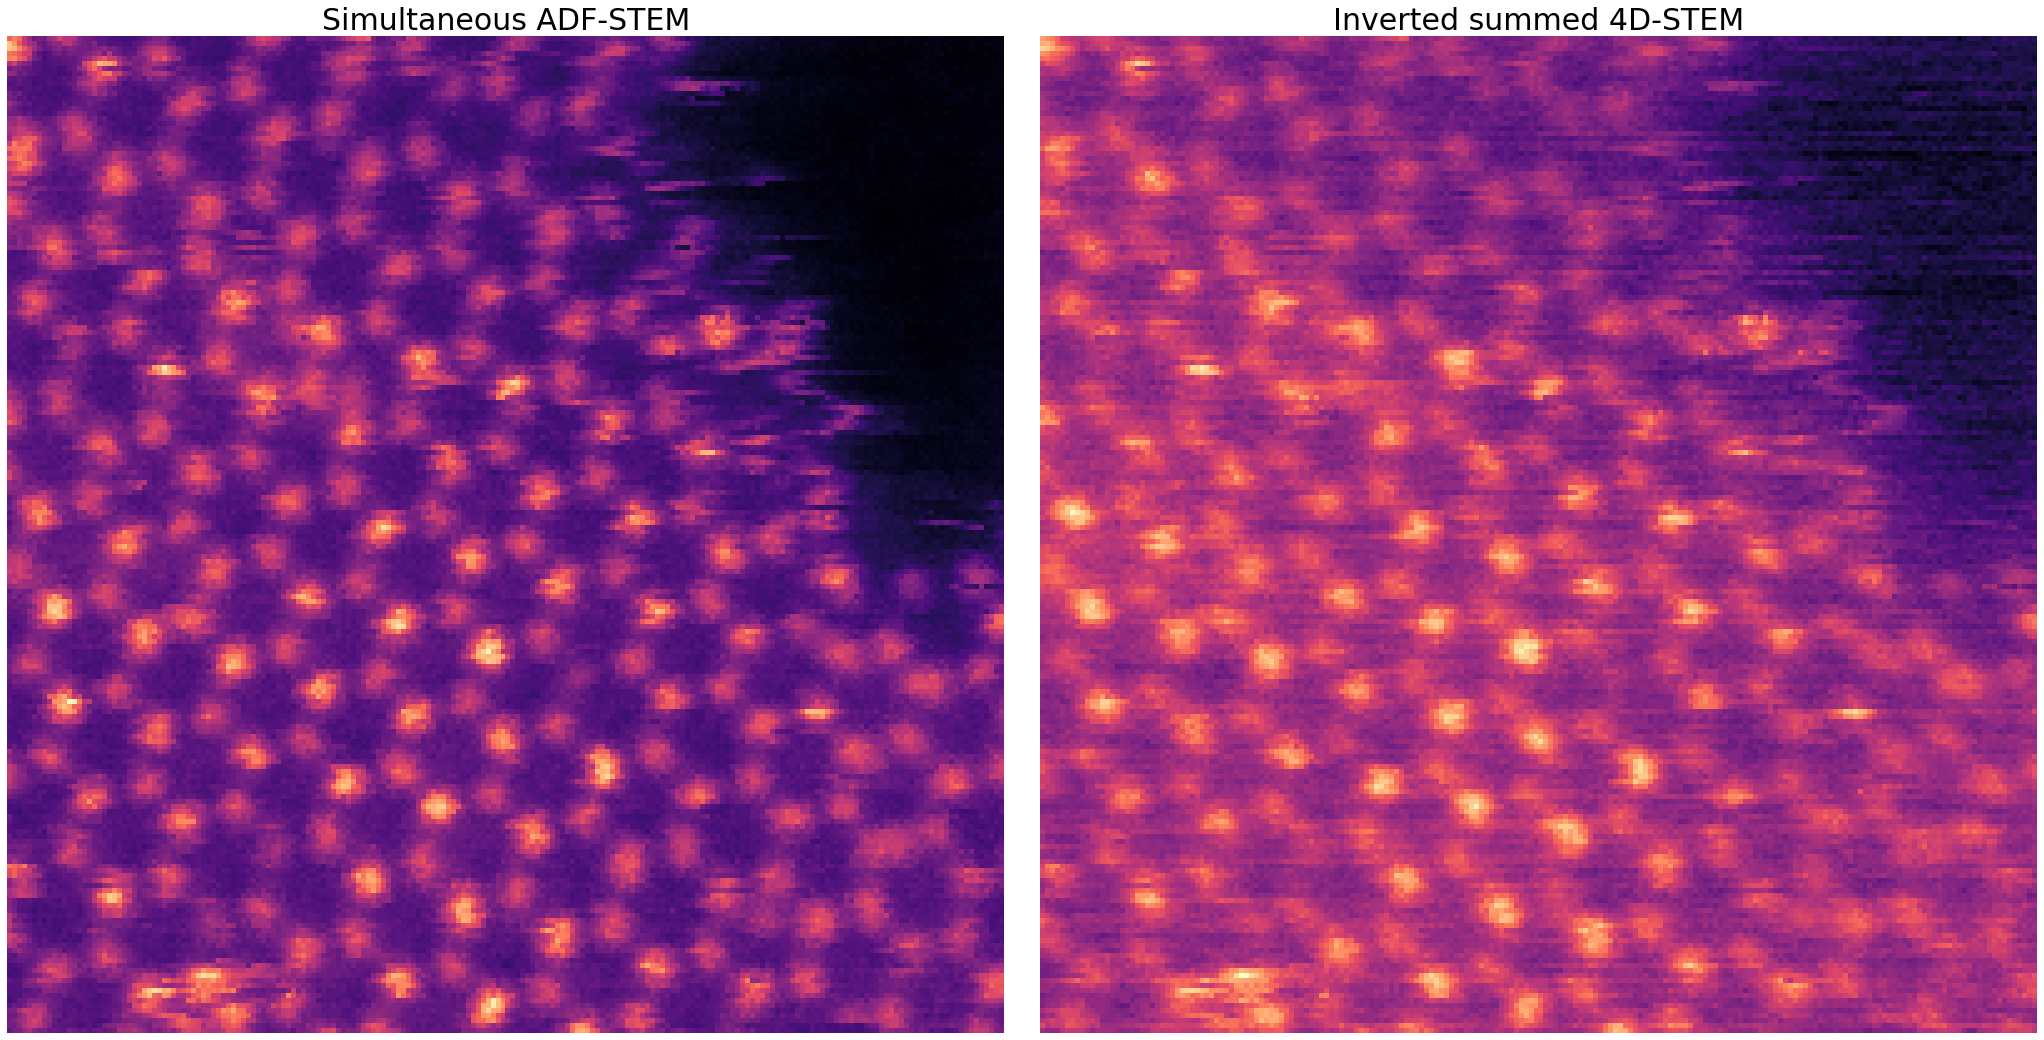

In [5]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,2,2)
plt.imshow(-np.sum(Data_4D,axis=(-1,-2)))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.tight_layout()
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/STEM.pdf')

In [6]:
Flat4D = np.reshape(Data_4D,(Data_4D.shape[0]*Data_4D.shape[1],Data_4D.shape[2],Data_4D.shape[3]))
CentralDisk = np.mean(Flat4D,axis=0)

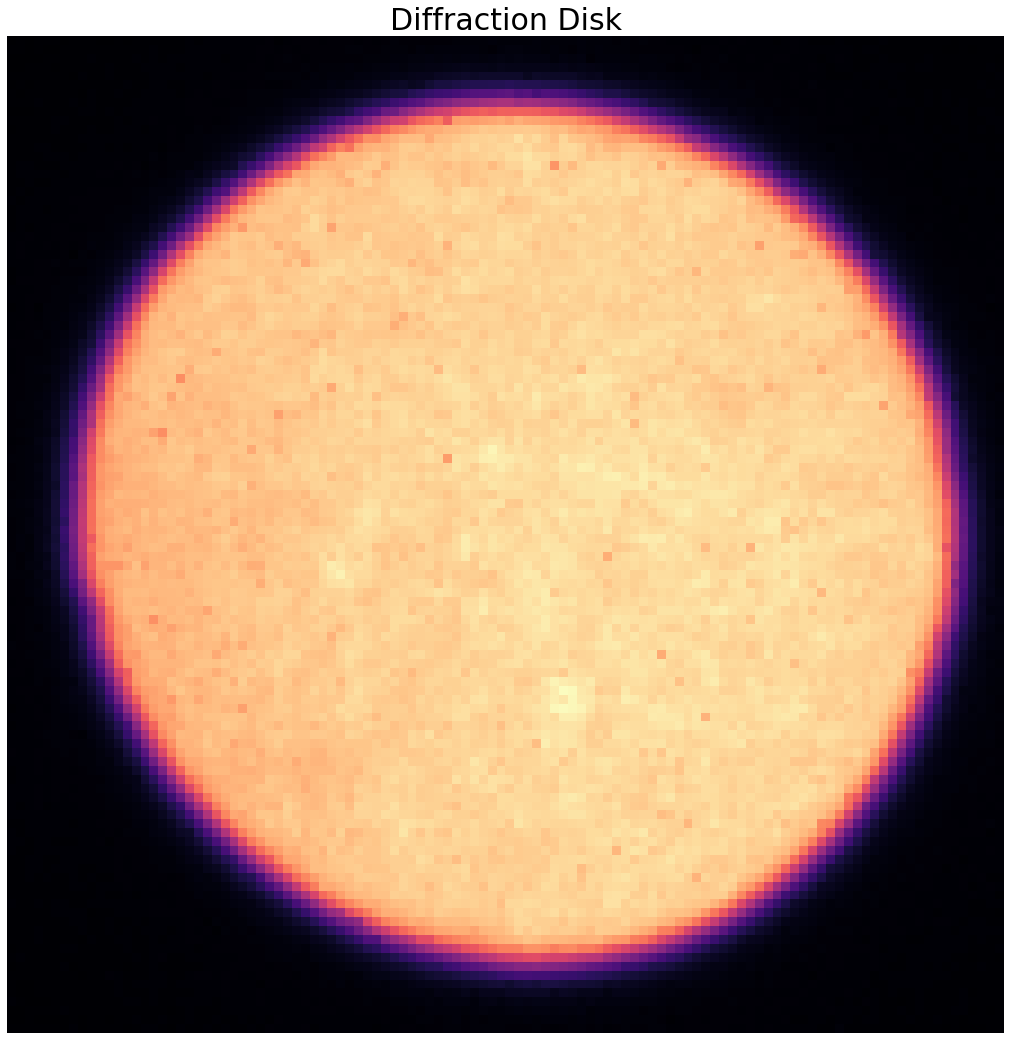

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/DiffractionDisk.pdf')

In [8]:
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)

In [9]:
beam_x,beam_y,beam_r

(57.38690920628227, 55.005660370340685, 48.715004520843976)

In [10]:
st.tic()
Flat4D = gpu_ssb.centerCBED(Flat4D,beam_x,beam_y,10)
CentralDisk = np.mean(Flat4D,axis=0)
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)
st.toc()

Elapsed time: 5.376869 seconds.



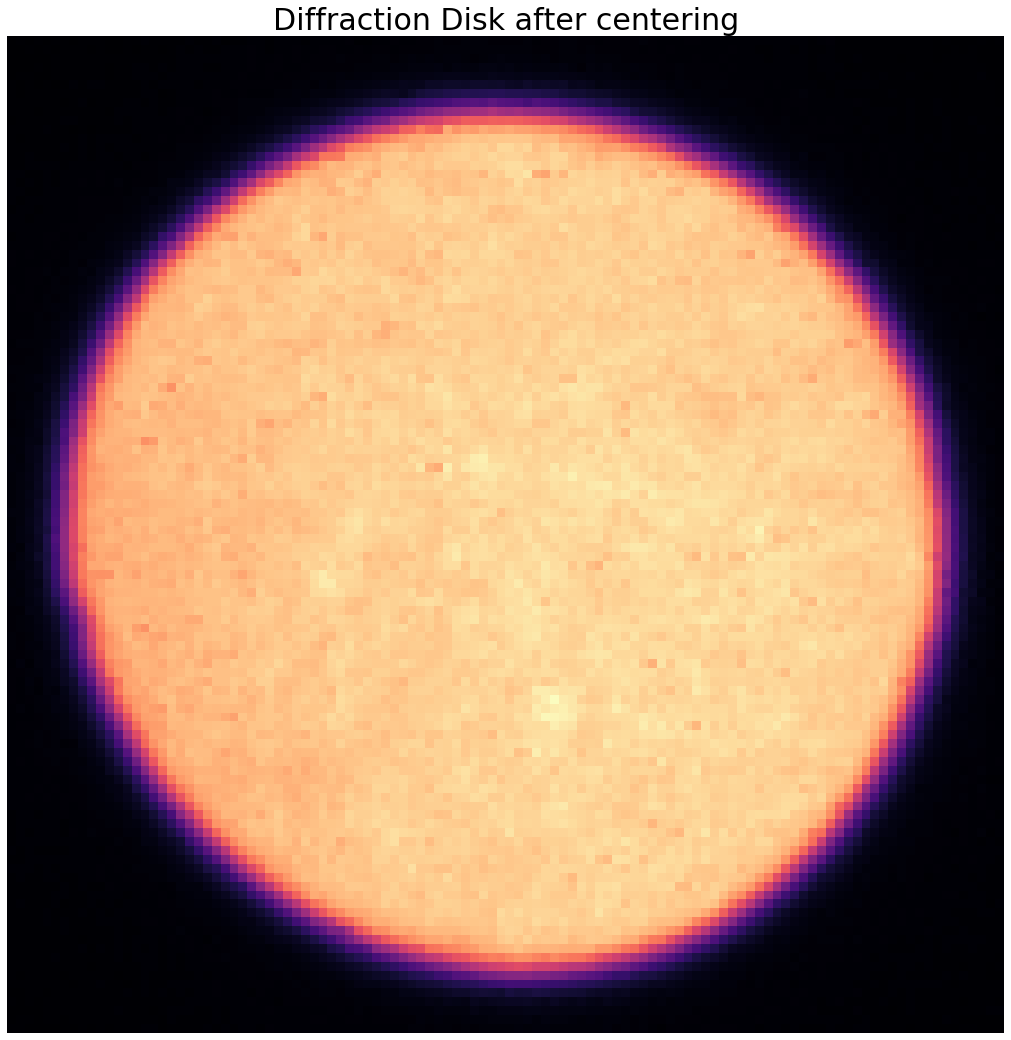

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk after centering')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/CenteredDiffractionDisk.pdf')

In [12]:
beam_x,beam_y,beam_r

(56.1501342844466, 55.93999343557604, 48.70707740403516)

In [13]:
st.tic()
dpc_x,dpc_y = gpu_ssb.get_flat_dpc(Flat4D)
dpc_x = np.reshape(dpc_x,(Data_4D.shape[0],Data_4D.shape[1]))
dpc_y = np.reshape(dpc_y,(Data_4D.shape[0],Data_4D.shape[1]))
st.toc()

Elapsed time: 0.854696 seconds.



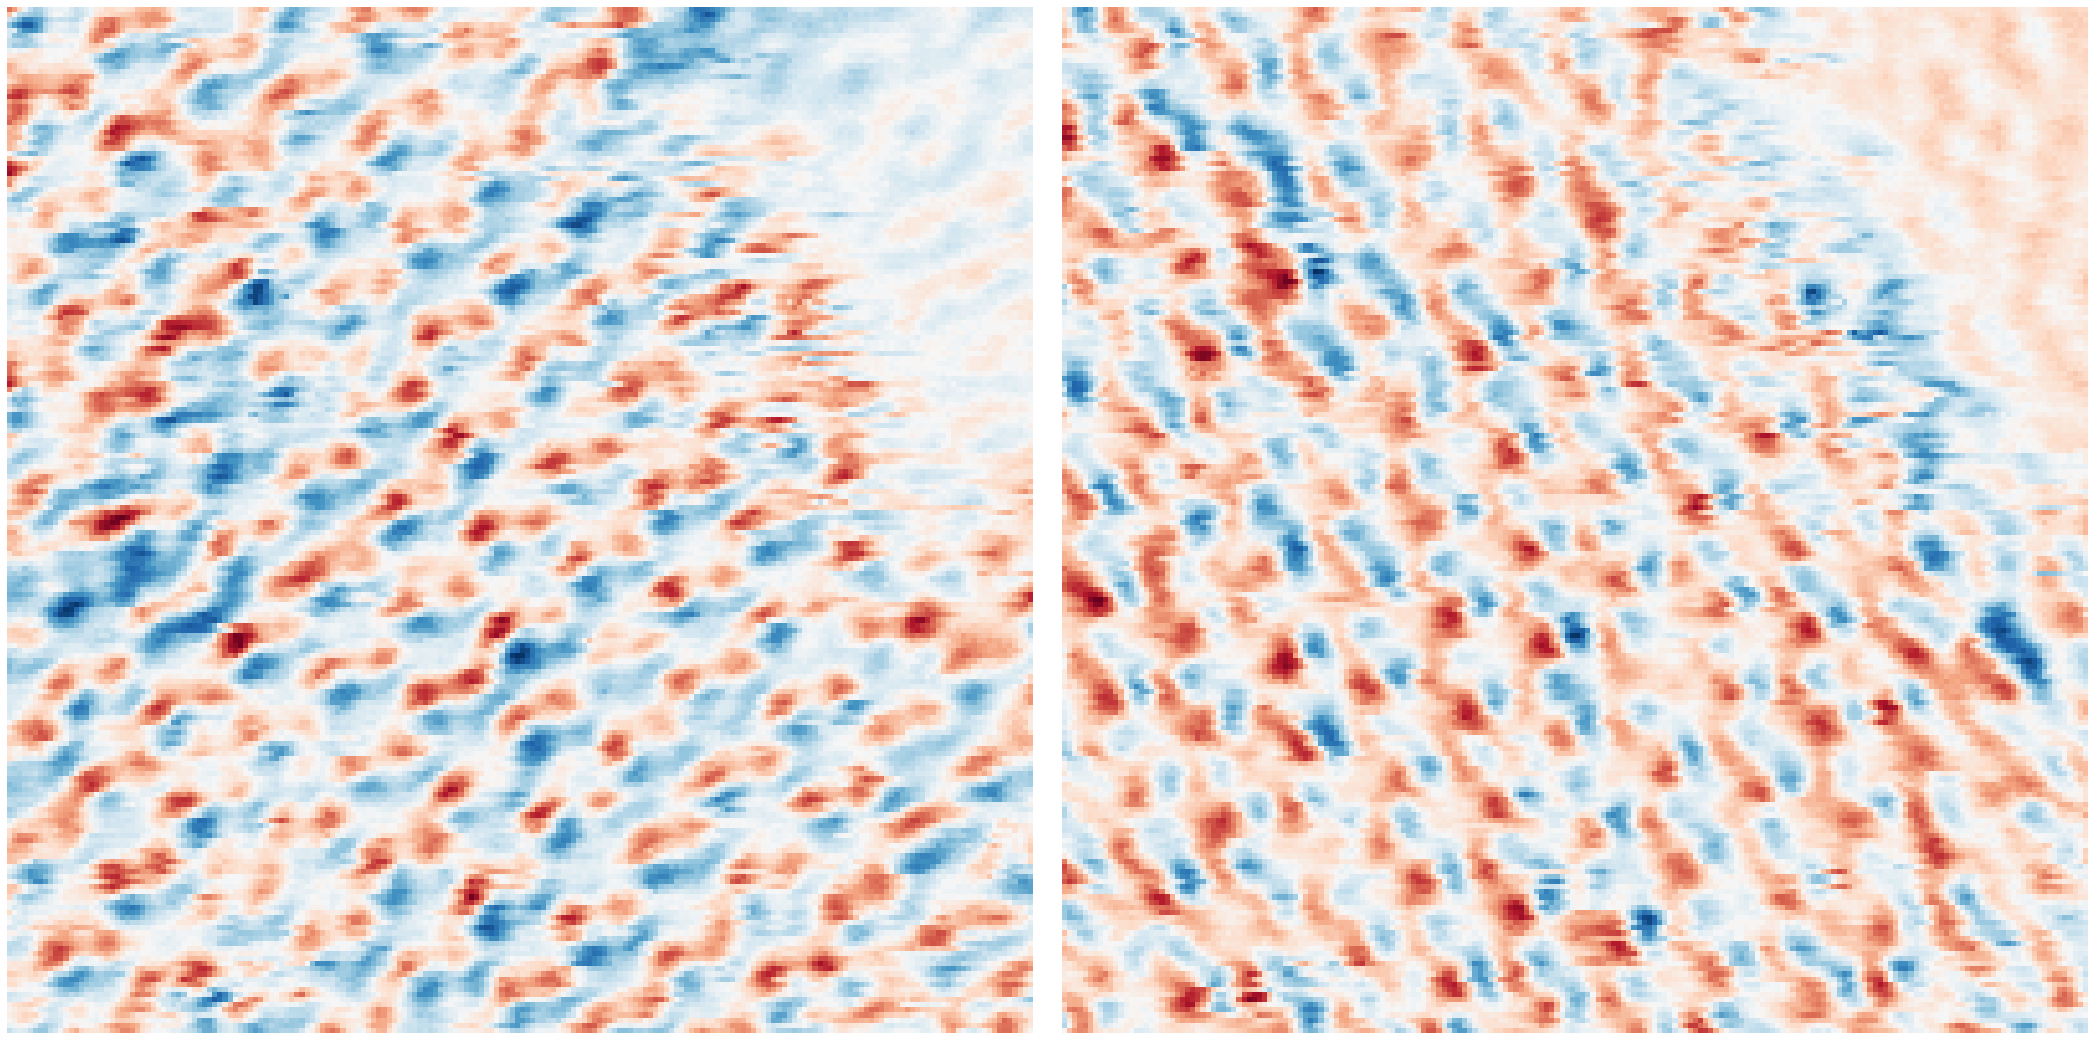

In [14]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_x,cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dpc_y,cmap='RdBu_r')
plt.axis('off')
plt.tight_layout()
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/DPC_Raw.pdf')

In [15]:
st.tic()
rotangle = gpu_ssb.optimize_angle(dpc_x,dpc_y,DataADF)
dpc_xC,dpc_yC = gpu_ssb.corrected_dpc(dpc_x,dpc_y,30.575357025229465)
st.toc()

Elapsed time: 0.710890 seconds.



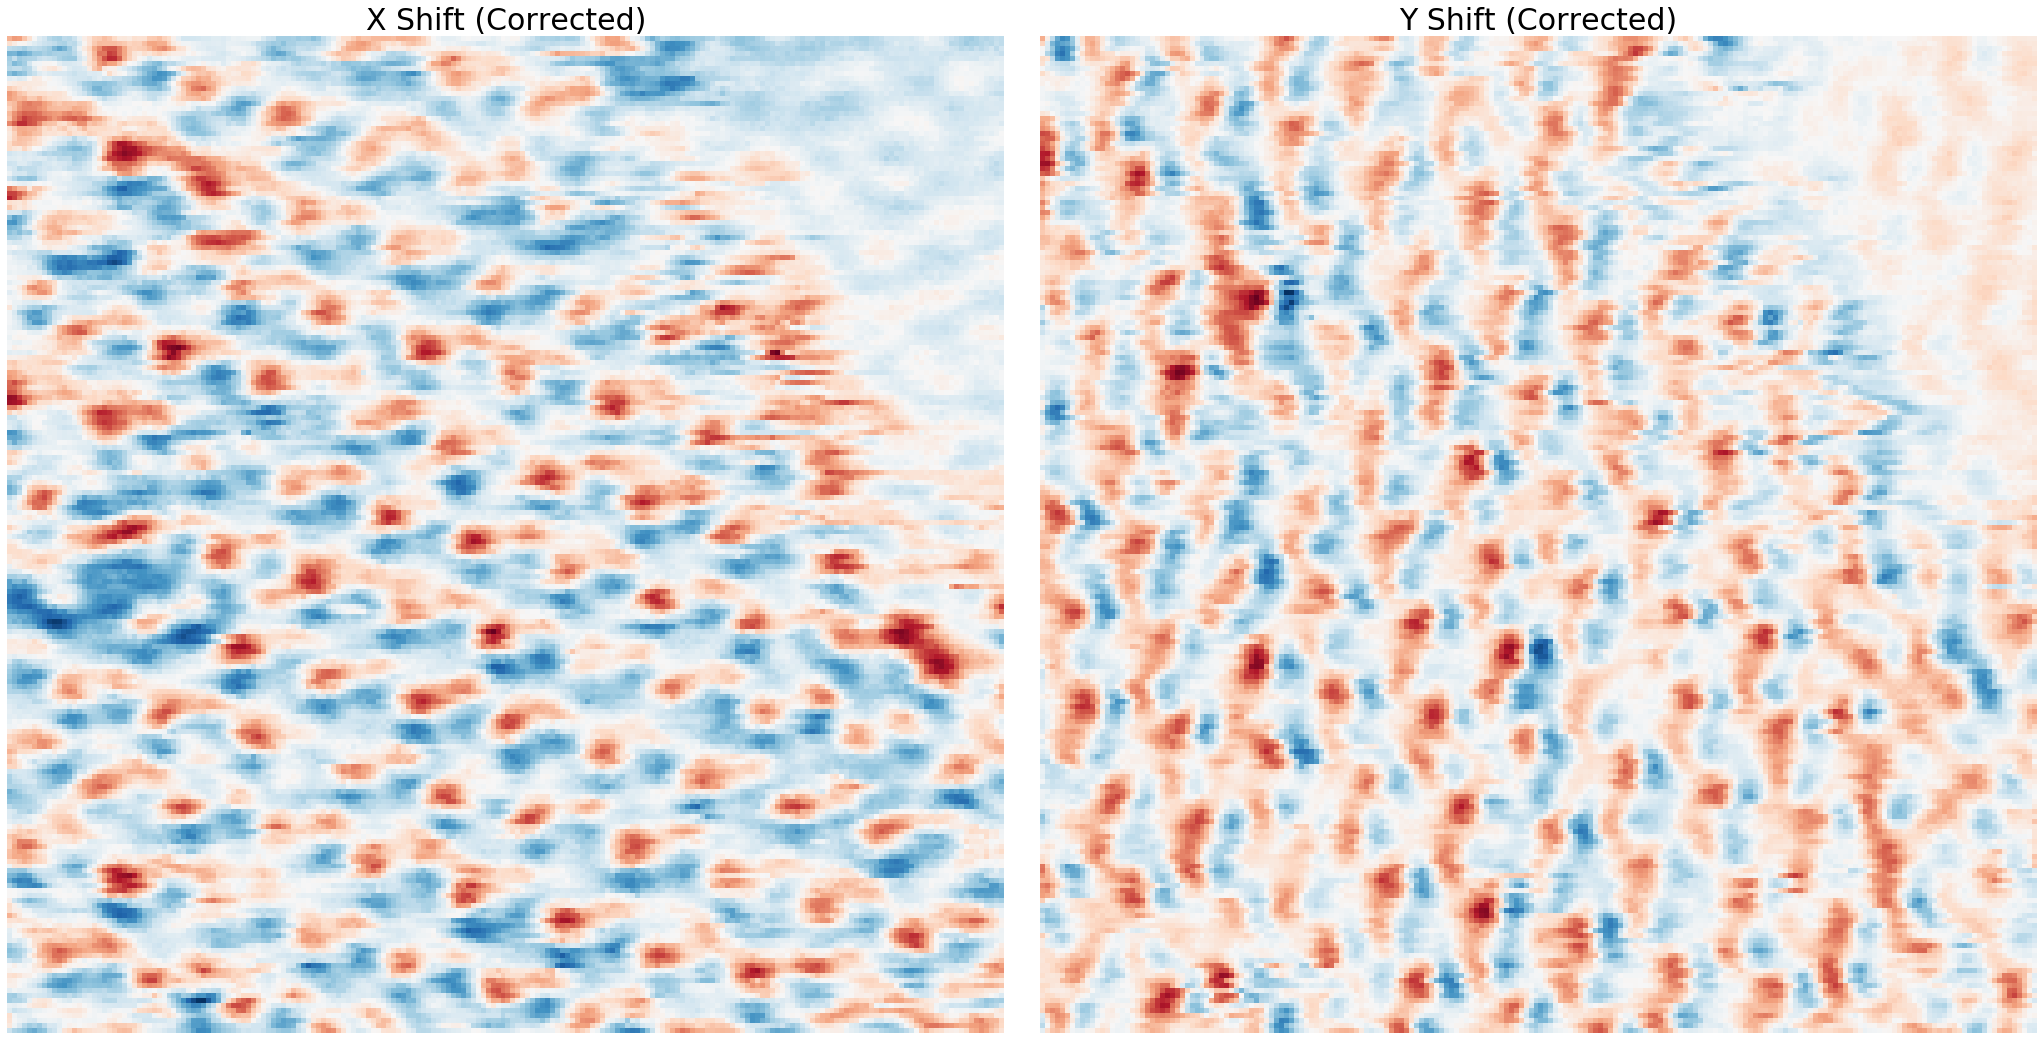

In [16]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_xC,cmap='RdBu_r')
plt.axis('off')
plt.title('X Shift (Corrected)')
plt.subplot(1,2,2)
plt.imshow(dpc_yC,cmap='RdBu_r')
plt.axis('off')
plt.title('Y Shift (Corrected)')
plt.tight_layout()
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/DPC_Rotated.pdf')

In [17]:
%timeit gpu_ssb.resizer2D(CentralDisk,(76/112))

282 µs ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit gpu_ssb.resizer4Df(Flat4D[0:100,:,:],2)

9.08 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit gpu_ssb.subpixel_pad4D(gpu_ssb.resizer4Df(Flat4D[0:100,:,:],2),Data_4D.shape[0:2],27)

129 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


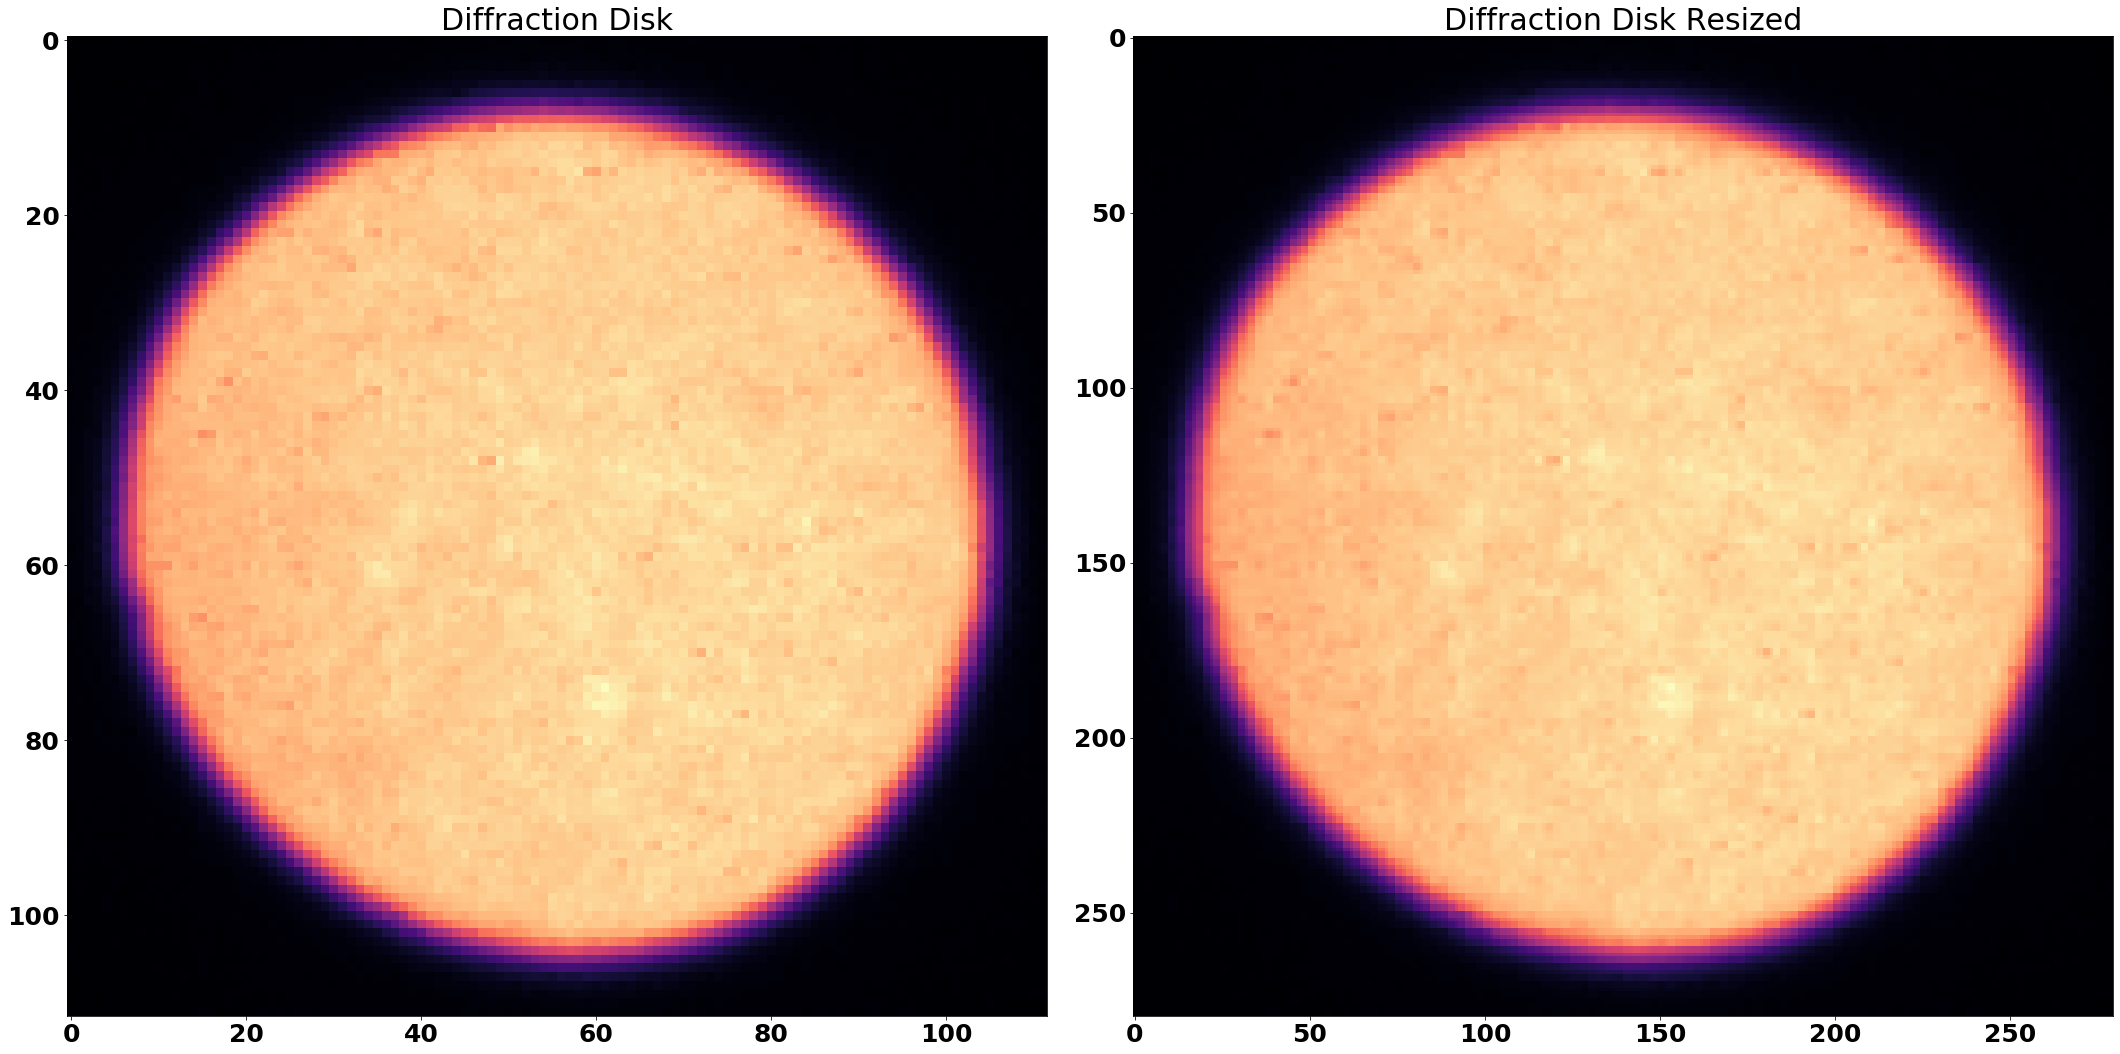

In [20]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(gpu_ssb.resizer2D(CentralDisk,0.4))
plt.title('Diffraction Disk Resized')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/ResizingTest.pdf')

In [21]:
calib = infoADF['spatial_calibrations'][0]['scale']
calib_pm = 1000*calib

In [22]:
st.tic()
cbed_sampler = gpu_ssb.get_sampling(Data_4D.shape,32,60,calib_pm,beam_r)
Flat4DR = gpu_ssb.resizer4Df(Flat4D,cbed_sampler)
st.toc()

Elapsed time: 6.271405 seconds.



In [23]:
new_radius = beam_r/cbed_sampler
new_radius

26.324145232506833

In [24]:
st.tic()
Flat4DP = gpu_ssb.subpixel_pad4D(Flat4DR,Data_4D.shape[0:2],new_radius,6)
st.toc()

Elapsed time: 47.013758 seconds.



In [25]:
del Flat4DR

In [26]:
del Flat4D

In [27]:
st.tic()
Flat4DP = gpu_ssb.gpu_rotator(Flat4DP,30.5,axes=(1,2))
st.toc()

Elapsed time: 23.444511 seconds.



In [28]:
st.tic()
Flat4DP = Flat4DP.astype(np.float32)
st.toc()

Elapsed time: 3.014935 seconds.



In [29]:
st.tic()
new_centraldisk = np.mean(Flat4DP,axis=0)
st.toc()

Elapsed time: 0.533575 seconds.



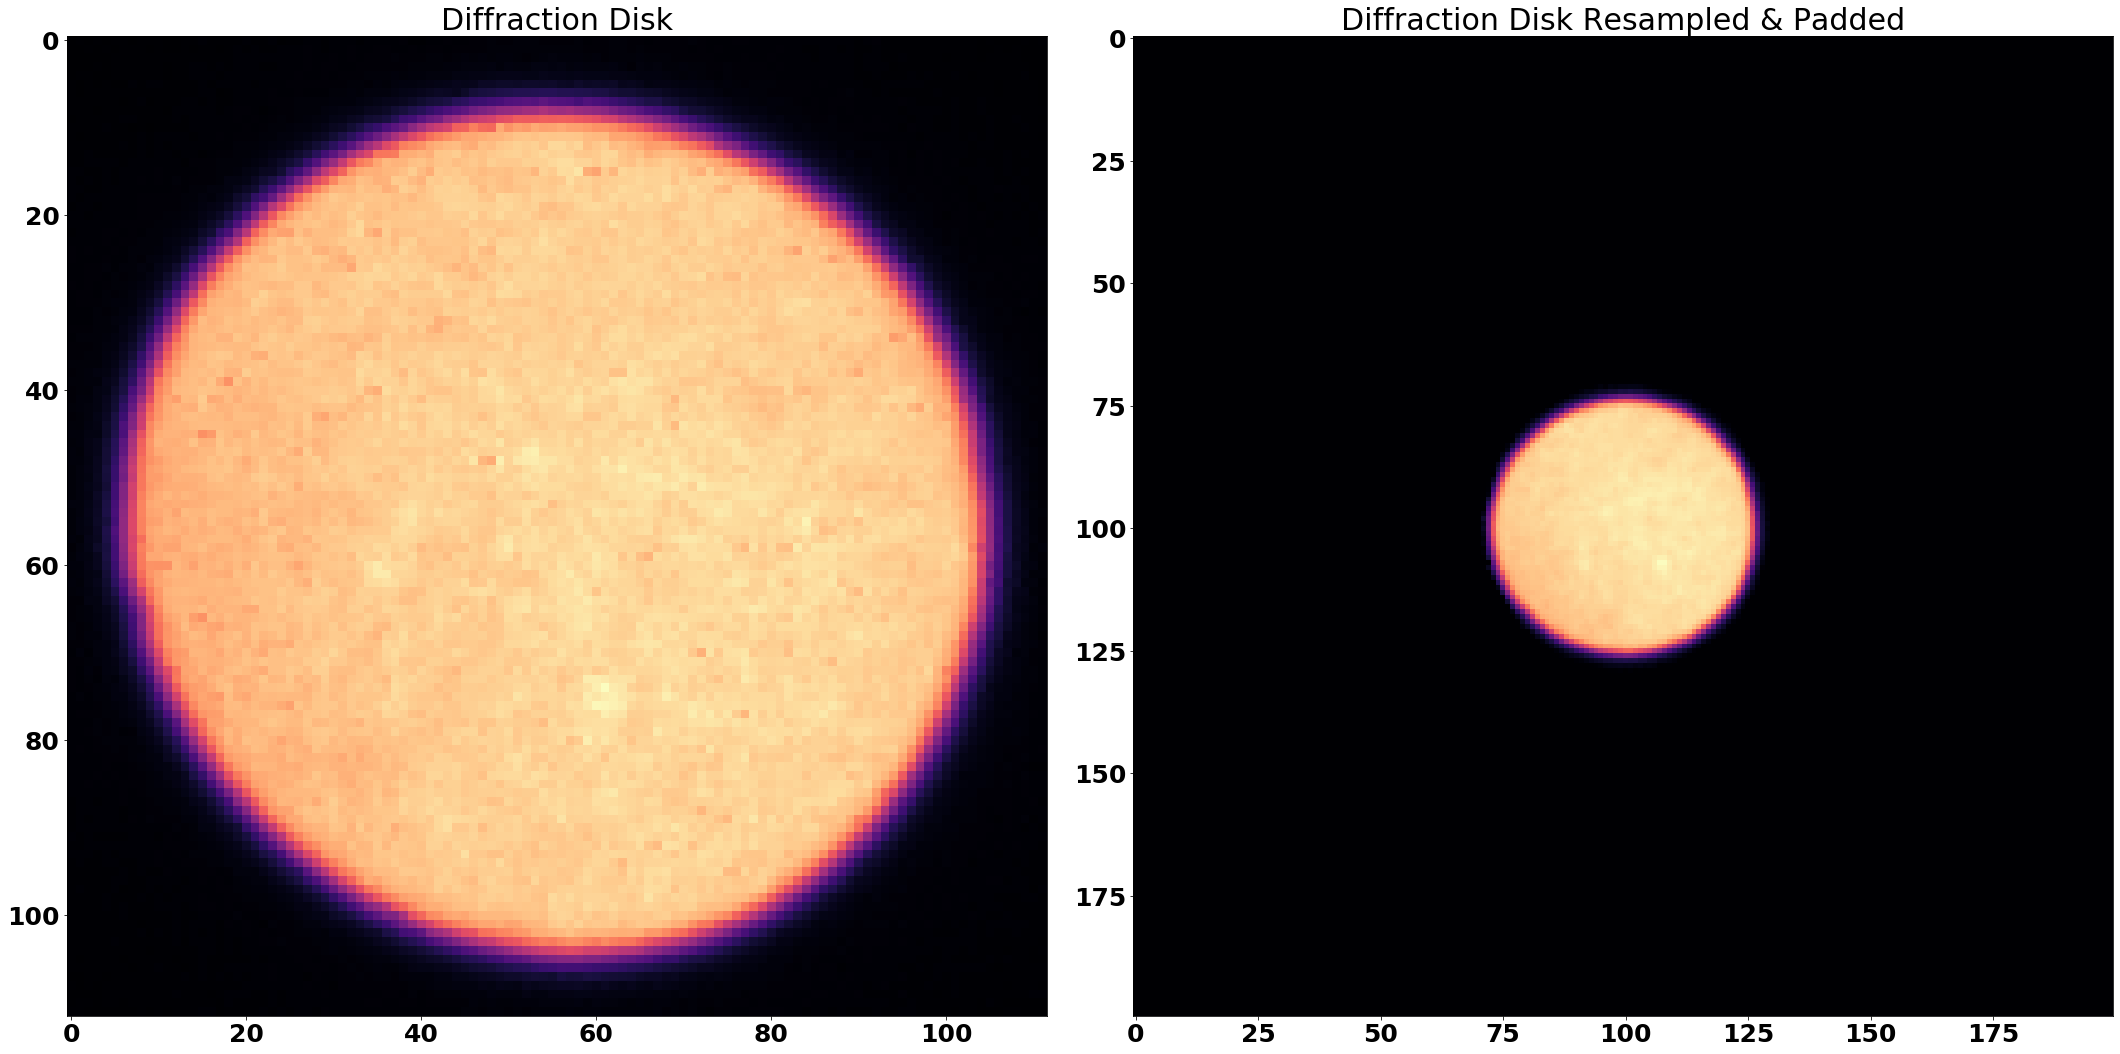

In [30]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(new_centraldisk)
plt.title('Diffraction Disk Resampled & Padded')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/ResampledDiffractionDisk.pdf')

In [31]:
st.tic()
Processed4D = np.reshape(Flat4DP,(Flat4DP.shape[1],Flat4DP.shape[2],Flat4DP.shape[1],Flat4DP.shape[2]))
Processed4D = gpu_ssb.get_G_matrix(Processed4D,20)
st.toc()

Elapsed time: 49.491197 seconds.



In [32]:
del Flat4DP

In [33]:
st.tic()
LSB,RSB = gpu_ssb.ssb_kernel(Processed4D,calib_pm,32,60,10)
st.toc()

Elapsed time: 96.648129 seconds.



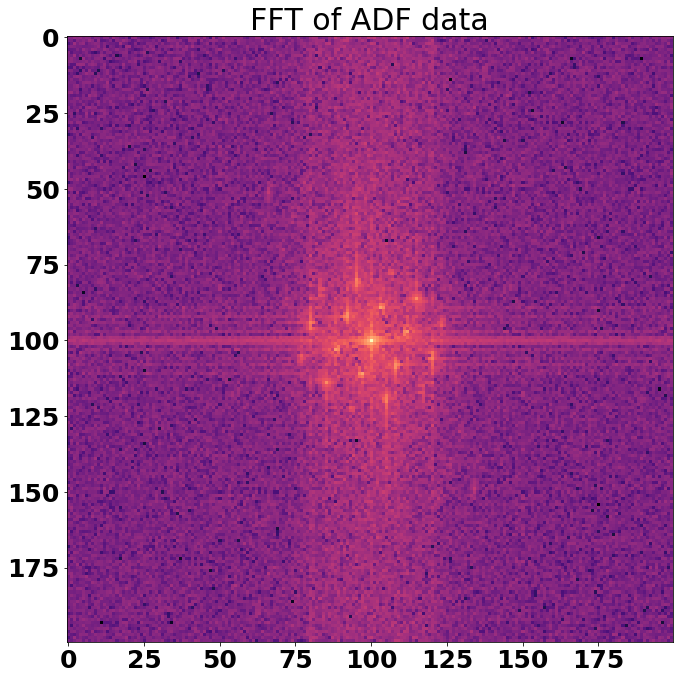

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(DataADF)))))
plt.title('FFT of ADF data')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/ADF_FFT.pdf')

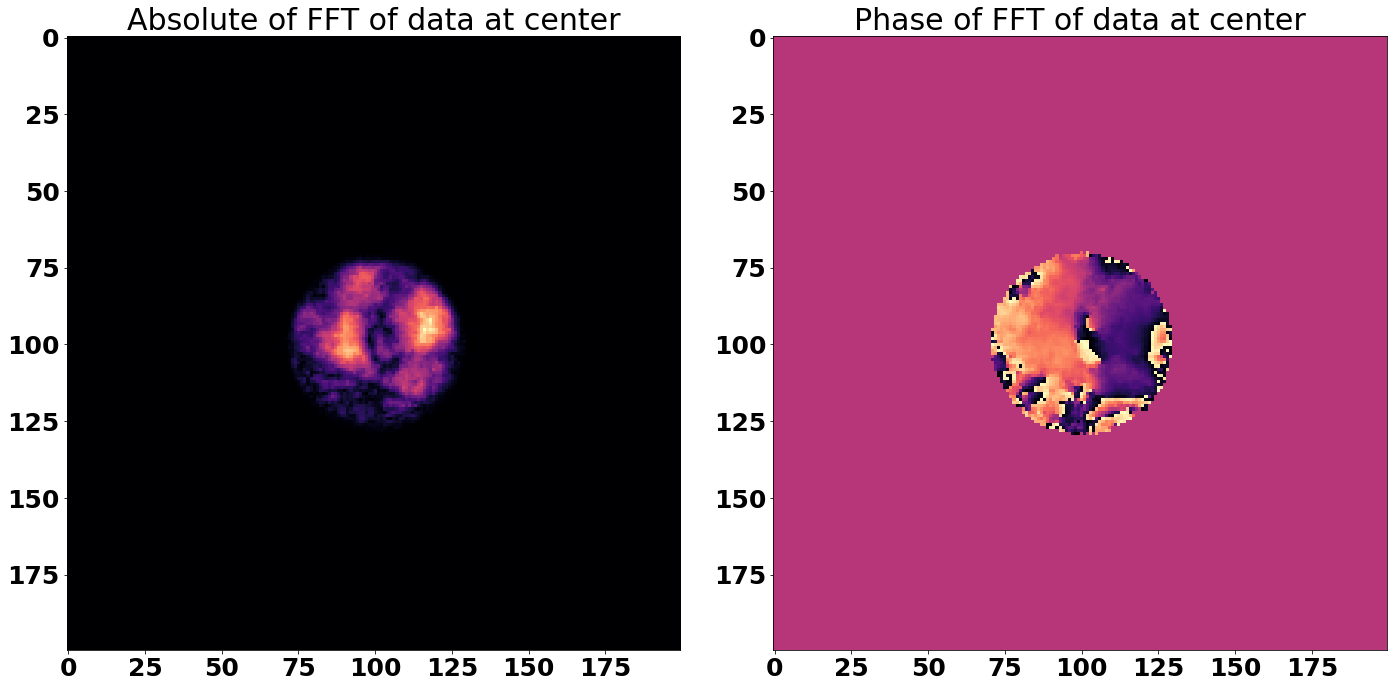

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(np.abs(Processed4D[:,:,87,120]))
plt.title('Absolute of FFT of data at center')

plt.subplot(1,2,2)
plt.imshow(np.angle(Processed4D[:,:,87,120]))
plt.title('Phase of FFT of data at center')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/RandomTrotter.pdf')

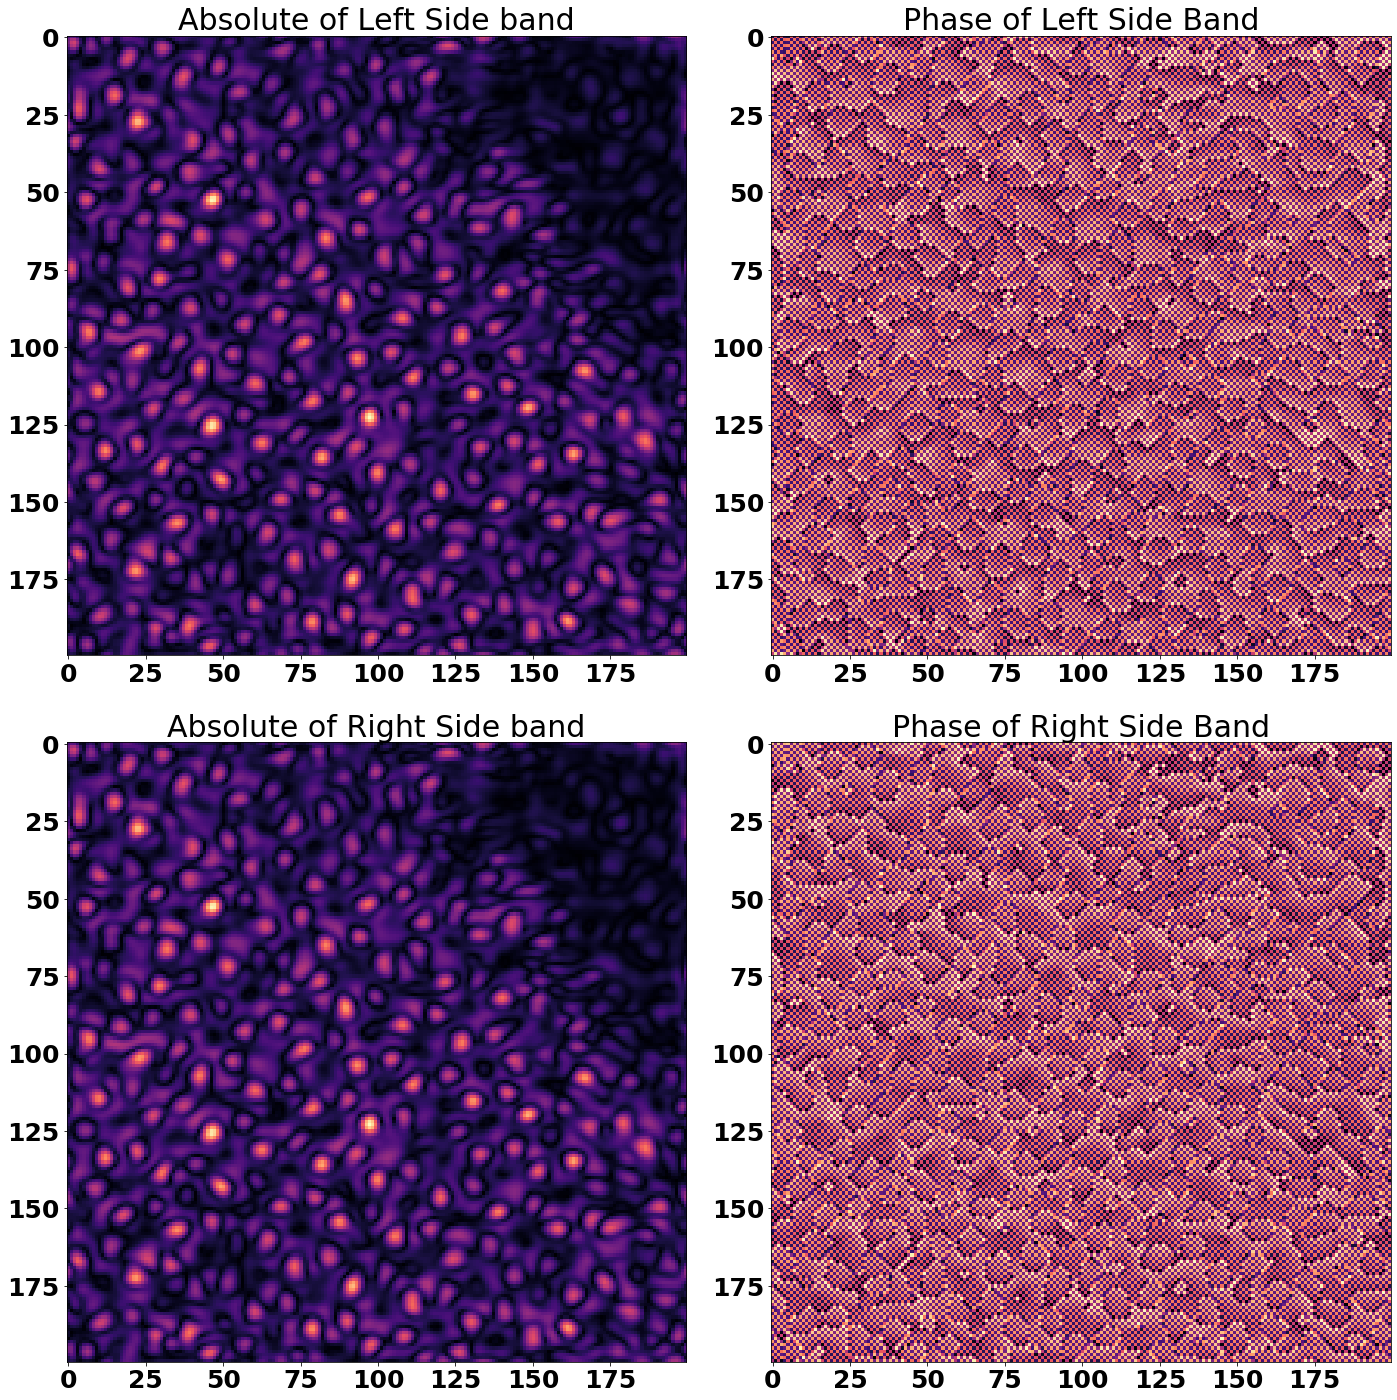

In [36]:
plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(np.abs(LSB))
plt.title('Absolute of Left Side band')

plt.subplot(2,2,2)
plt.imshow(np.angle(LSB))
plt.title('Phase of Left Side Band')

plt.subplot(2,2,3)
plt.imshow(np.abs(RSB))
plt.title('Absolute of Right Side band')

plt.subplot(2,2,4)
plt.imshow(np.angle(RSB))
plt.title('Phase of Right Side Band')
plt.savefig('C:/Debangshu Research/ptycho_testing/GPU Results/SSB_Results.pdf')